# Online Exposure-Time Calculator Calibration

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
from pathlib import Path

In [8]:
import scipy.interpolate
import astropy.units as u
import astropy.constants
import astropy.table
import astropy.cosmology
LCDM = astropy.cosmology.Planck15

In [7]:
import specsim.simulator

In [9]:
from sklearn import linear_model

In [10]:
import skycalc_cli.skycalc

## Formalism

#### Signal

$$
S(t) = \alpha \, \int_{t_\text{open}}^{t}\, s(t)
$$

$$
\alpha = \alpha_0\,X^{-p} 10^{-2 A_g E_{B-V}/2.5}
$$

$$
s(t_\text{GFA}) = (a + b \theta + c \theta^2)\, T^{r_\text{GFA}}
$$

#### Background

$$
B(t) = B_\text{read} + \beta\, \int_{t_\text{open}}^{t}\, b(t)
$$

$$
\beta = \beta_0\, X\, f_\text{moon}(t_\text{open})
$$

$$
b(t_\text{SC}) = r_\text{SC} F
$$

#### SNR

$$
\nu(t) = \frac{S(t)}{\left(B(t) + S(t)\right)^{1/2}}
$$

## Calibration Simulations

In [11]:
desi = specsim.simulator.Simulator('desi', num_fibers=100)

In [12]:
desi.fiberloss = 'galsim'

In [13]:
def generate_elg_profiles(z, seed=123, verbose=False):
    """ELG profiles are assumed to be disk (Sersic n=1) only.
    """
    gen = np.random.RandomState(seed)
    nsrc = len(z)
    source_fraction = np.zeros((nsrc, 2))
    source_half_light_radius = np.zeros((nsrc, 2))
    source_minor_major_axis_ratio = np.zeros((nsrc, 2))
    source_position_angle = 360. * gen.normal(size=(nsrc, 2))
    # Precompute cosmology scale factors.
    angscale = (
        LCDM.angular_diameter_distance(1.0) /
        LCDM.angular_diameter_distance(z)).to(1).value
    if verbose:
        print(f'mean n(z) DA(1.0)/DA(z) = {np.mean(angscale):.3f}')
    # Disk only with random size and ellipticity.
    source_fraction[:, 0] = 1.
    source_half_light_radius[:, 0] = 0.427 * np.exp(0.25 * gen.normal(size=nsrc)) * angscale
    source_minor_major_axis_ratio[:, 0] = np.minimum(0.99, 0.50 * np.exp(0.15 * gen.normal(size=nsrc)))
    if verbose:
        print(f'mean HLR = {np.mean(source_half_light_radius[:, 0]):.3f}"')
    return dict(
        source_fraction=source_fraction,
        source_half_light_radius=source_half_light_radius,
        source_minor_major_axis_ratio=source_minor_major_axis_ratio,
        source_position_angle=source_position_angle)

In [14]:
def calibrate(simulator, flux_ref=1.0e-18, seed=123):
    
    gen = np.random.RandomState(seed)
    
    # Generate random focal plane (x,y) positions for each fiber in mm units.
    nfibers = simulator.num_fibers
    focal_r = np.sqrt(gen.uniform(size=nfibers)) * simulator.instrument.field_radius
    phi = 2 * np.pi * gen.uniform(size=nfibers)
    xy = (np.vstack([np.cos(phi), np.sin(phi)]) * focal_r).T

    wlen = np.array([desi.simulated['wavelength'][0],
                     desi.simulated['wavelength'][-1]])
    flux = np.array([flux_ref, flux_ref])
    simulator.source.update_in(
        'Flat', 'elg',
        wlen * u.Angstrom, flux * u.erg/(u.s * u.cm**2 * u.Angstrom), z_in=0.)
    simulator.source.update_out(z_out=0.)

    # Generate source profiles for each target at this redshift. Since the seed is
    # fixed, only the redshift scaling of the HLR will change.
    sources = generate_elg_profiles(z=np.full(nfibers, 1.0), seed=seed)
    # Simulate each source.
    simulator.simulate(focal_positions=xy, **sources)

In [15]:
calibrate(desi)

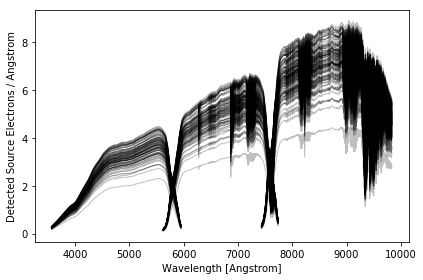

In [16]:
def plot_signal():
    for out in desi.camera_output:
        wlen = out['wavelength']
        dwlen = np.gradient(wlen).reshape(-1, 1)
        plt.plot(wlen, out['num_source_electrons'] / dwlen, 'k-', lw=1, alpha=0.25)
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Detected Source Electrons / Angstrom')
    plt.tight_layout()
    plt.savefig('etc_source.png')
    
plot_signal()

SNR: 14.1794400955
alpha: 22.2290510549 elec/sec
beta: 2395.43750873 elec/sec
B0: 40004.0857915 elec


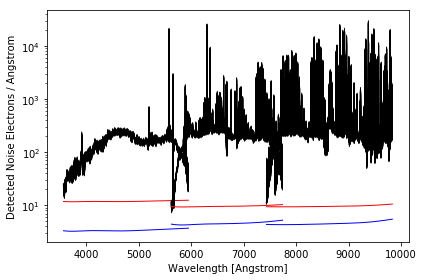

In [17]:
def plot_bg():
    snr2, nsrctot, nbgtot, nread = 0, 0, 0, 0
    for out in desi.camera_output:
        wlen = out['wavelength'].data
        dwlen = np.gradient(wlen)
        nsrc = out['num_source_electrons'].data
        nelec = out['num_sky_electrons'].data
        sel = wlen > 6000
        nsrctot += nsrc[sel].sum() / desi.num_fibers
        nbgtot += nelec[sel].sum() / desi.num_fibers
        nread += out['read_noise_electrons'][sel].sum() / desi.num_fibers
        plt.plot(wlen, nelec / dwlen.reshape(-1, 1), 'k-', lw=1, alpha=0.1)
        plt.plot(wlen, out['read_noise_electrons'][:,0].data / dwlen, 'r-', lw=1)
        plt.plot(wlen, out['num_dark_electrons'][:,0].data / dwlen, 'b-', lw=1)
    plt.yscale('log')
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Detected Noise Electrons / Angstrom')
    snr = nsrctot / np.sqrt(nsrctot + nbgtot + nread)
    print('SNR:', snr)
    texp = desi.observation.exposure_time.to(u.s).value
    print('alpha:', nsrctot / texp, 'elec/sec')
    print('beta:', nbgtot / texp, 'elec/sec')
    print('B0:', nread, 'elec')
    plt.tight_layout()
    plt.savefig('etc_bg.png')
    
plot_bg()

### Seeing Calibration

Calculate average fiberloss over the focal plane on a grid of atmospheric seeing values:

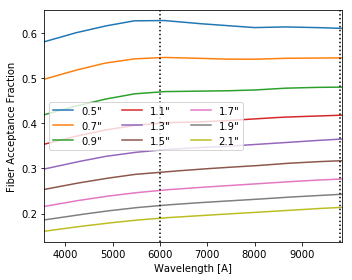

In [74]:
def seeing_calib(simulator=desi, wlen_lo=6000, wlen_hi=9800):
    fwhm_vec = np.arange(0.5, 2.3, 0.2)
    wlen = simulator.simulated['wavelength'].data
    sel = (wlen > wlen_lo) & (wlen < wlen_hi)
    thru = []
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    for fwhm in fwhm_vec:
        tag = f'{fwhm:.1f}"'
        simulator.atmosphere.seeing_fwhm_ref = fwhm * u.arcsec
        calibrate(simulator)
        floss = np.mean(simulator.simulated['fiberloss'].data, axis=1)
        ax.plot(wlen, floss, label=tag)
        thru.append(np.mean(floss[sel]))
    ax.legend(ncol=3)
    ax.axvline(wlen_lo, ls=':', c='k')
    ax.axvline(wlen_hi, ls=':', c='k')
    ax.set_xlim(wlen[0], wlen[-1])
    ax.set_xlabel('Wavelength [A]')
    ax.set_ylabel('Fiber Acceptance Fraction')
    plt.tight_layout()
    plt.savefig('seeing_calib.png')
    return fwhm_vec, np.array(thru)
    
fwhm, thru = seeing_calib()

a, b, c = (2.047603089357477, -1.1859023502185153, 0.21230536849825615)


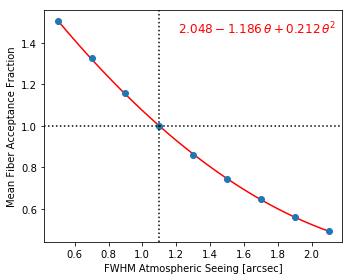

In [75]:
def fit_seeing_calib(fwhm=fwhm, thru=thru, fwhm0=1.1):
    # Fit a second-order polynomial.
    model = linear_model.LinearRegression(fit_intercept=False)
    features = lambda fwhm: np.array([0.*fwhm + 1., fwhm, fwhm ** 2]).T
    X = features(fwhm)
    model.fit(X, thru)
    # Normalize to the nominal value.
    thru0 = model.predict(features(np.array([fwhm0])))
    a, b, c = model.coef_ / thru0
    print('a, b, c =', (a, b, c))
    assert np.allclose(a + b * fwhm0 + c * fwhm0 ** 2, 1.0)

    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    x = np.linspace(fwhm[0], fwhm[-1], 50)
    y = a + b * x + c * x ** 2
    ax.plot(x, y, 'r-')
    ax.plot(fwhm, thru / thru0, 'o')
    ax.axvline(fwhm0, ls=':', c='k')
    ax.axhline(1., ls=':', c='k')
    ax.set_xlabel('FWHM Atmospheric Seeing [arcsec]')
    ax.set_ylabel('Mean Fiber Acceptance Fraction')

    label = f'${a:.3f} {b:+.3f}\,\\theta {c:+.3f}\,\\theta^2$'
    ax.text(0.98, 0.9, label, horizontalalignment='right',
            transform=ax.transAxes, fontsize='large', color='r')
    plt.tight_layout()
    plt.savefig('seeing_fit.png')
    
fit_seeing_calib()

### Sky Brightness Calibration

Load sky camera throughput:

In [18]:
sc_thru = astropy.table.Table.read('skycam_throughput.fits', hdu=1)
sc_wlen = sc_thru['WLEN'].data
sc_nofilt = scipy.interpolate.interp1d(
    sc_wlen, sc_thru['NOFILT'].data, kind='linear', assume_sorted=True,
    fill_value=0., bounds_error=False, copy=True)
sc_dark = scipy.interpolate.interp1d(
    sc_wlen, sc_thru['NOFILT'].data * sc_thru['610FS10'].data, kind='linear', assume_sorted=True,
    fill_value=0., bounds_error=False, copy=True)
sc_bright = scipy.interpolate.interp1d(
    sc_wlen, sc_thru['NOFILT'].data * sc_thru['450FS80'].data, kind='linear', assume_sorted=True,
    fill_value=0., bounds_error=False, copy=True)

Load GFA throughput:

In [45]:
gfa_thru_t = astropy.table.Table.read('GFAthru.csv')
gfa_thru = scipy.interpolate.interp1d(
    gfa_thru_t['wlen'].data, gfa_thru_t['thru'].data, kind='linear', assume_sorted=True,
    fill_value=0., bounds_error=False, copy=True)

Load DESI throughputs:

In [19]:
DESIMODEL = Path(os.getenv('DESIMODEL'))
assert DESIMODEL.exists

In [20]:
desi_thru = {}
for band in 'brz':
    t = astropy.table.Table.read(DESIMODEL / 'data' / 'throughput' / f'thru-{band}.fits', hdu=1)
    desi_thru[band] = scipy.interpolate.interp1d(
        t['wavelength'].data, t['throughput'].data, kind='linear', assume_sorted=True,
        fill_value=0., bounds_error=False, copy=True)

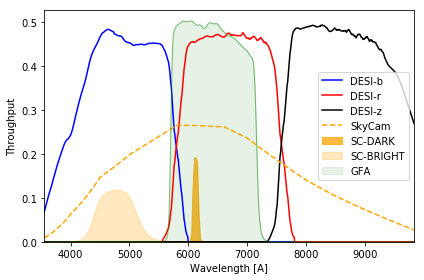

In [48]:
def plot_thru():
    wlen = np.arange(desi.simulated['wavelength'].data[0], desi.simulated['wavelength'].data[-1], 10)
    for band, color in zip('brz', 'brk'):
        plt.plot(wlen, desi_thru[band](wlen), c=color, label=f'DESI-{band}')
    plt.plot(wlen, sc_nofilt(wlen), '--', c='orange', label='SkyCam')
    plt.fill_between(wlen, sc_dark(wlen), color='orange', alpha=0.75, label='SC-DARK')
    plt.fill_between(wlen, sc_bright(wlen), color='orange', alpha=0.25, label='SC-BRIGHT')
    plt.fill_between(wlen, gfa_thru(wlen), color='green', alpha=0.1, label='GFA')
    plt.plot(wlen, gfa_thru(wlen), 'g-', lw=1, alpha=0.5)
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Throughput')
    plt.legend()
    plt.xlim(wlen[0], wlen[-1])
    plt.ylim(0, None)
    plt.tight_layout()
    plt.savefig('xcalib-thru.png')
    
plot_thru()

Source transmission variations:
 - Rayleigh: scattering off molecules (O2, N2, ...) in dry atmosphere.
 - Mie: scattering off aerosols (silicate dust, sea salt, soot, sulphuric acid droplets, ...).
 - Absorption: mostly by molecular oxygen (O2), water vapor (H2O) and ozone (O3).
 
Sky brightness variations:
 - thin clouds absorbing or scattering moonlight and terrestrial sources.
 - airglow continuum: low variability, varies with time after sunset?
 - airglow emission lines in 5 variability classes (Fig.13 of Noll 2012).

In [22]:
sc = skycalc_cli.skycalc.SkyModel()

In [23]:
sbunit = u.erg / (u.Angstrom * u.s * u.cm ** 2 * u.arcsec ** 2)

See [here](https://www.eso.org/observing/etc/doc/skycalc/helpskycalccli.html) for skycalc inputs and outputs:

In [123]:
def get_skycalc(target_alt=20., moon_alt=-30., moon_sep=None, moon_frac=0.0, save=None):
    
    moon_sep_min = np.abs(target_alt - moon_alt)
    moon_sep_max = min(180, 180 - target_alt - moon_alt)
    if moon_sep is None:
        moon_sep = moon_sep_max
    # Check for a valid moon separation angle.
    if (moon_sep < moon_sep_min) or (moon_sep > moon_sep_max):
        print(f'moon_sep must be between {moon_sep_min:.1f} and {moon_sep_max:.1f}')
        return
    
    # Create a unique filename for these parameters.
    name = f'skycalc/skycalc_{target_alt:.1f}_{moon_alt:.1f}_{moon_sep:.1f}_{moon_frac:.1f}.fits'
    print(name)

    # Calculate the airmass of this observation.
    cosz = np.cos(np.radians(90 - target_alt))
    airmass = max(1, (cosz + 0.025 * np.exp(-11 * cosz)) ** -1)
    print(f'airmass X={airmass:.3f}')

    # Calculate the moon-sun separation angle.
    phi = np.arccos(2 * moon_frac - 1.) / np.pi
    moon_sun_sep = 180 * (1 - phi)
    
    if not os.path.exists(name):
        # Initialize SkyCalc parameters.
        params = dict(
            airmass=airmass,
            moon_sun_sep=moon_sun_sep,
            moon_target_sep=moon_sep,
            moon_alt=moon_alt,
            ecl_lon=-80,
            ecl_lat=0,
            season=0,
            time=0,
            vacair='vac',
            wmin=300.,
            wmax=1100.,
            wdelta=0.5,
            observatory='2640', #paranal
        )
        try:
            # Get results from the server.
            sc.callwith(params)
        except SystemExit:
            print('Ignoring server error.')
        sc.write(name)
    else:
        print('Using cached results.')
        
    results = astropy.table.Table.read(name, hdu=1)
    # Read results in microns and photons/s/m2/μm/arcsec2.
    lam = results['lam'].data * 1e4 # convert from um to Angstrom
    # SkyCalc calculates radiance.
    unit_in = u.photon / (u.s * u.m ** 2 * u.um * u.arcsec ** 2)
    # Convert to photon rate / A into a fiber (assuming perfect telescope transmission)
    fiber_area = 1.656 * u.arcsec ** 2
    Aeff = 8.67871 * u.m ** 2 # DESI primary adjusted for central obscuration
    unit_out = u.photon / (u.s * u.Angstrom)
    conv = (fiber_area * Aeff * unit_in).to(unit_out).value

    
    def emission(continuum_scale, lines_scale):
        return conv * (
            results['flux'].data +
            results['flux_arc'].data * (continuum_scale - 1.) +
            results['flux_ael'].data * (lines_scale - 1.))
    
    def transmission(aerosol_scale, absorb_scale):
        return (
            results['trans'].data *
            results['trans_ms'].data ** (aerosol_scale - 1.) *
            results['trans_ma'].data ** (absorb_scale - 1.))

    return lam, emission, transmission

In [133]:
SKY = (
    ('DARK X=1.0', *get_skycalc(target_alt=90., moon_alt=-30., moon_sep=120, moon_frac=0)),
    ('DARK X=1.6', *get_skycalc(target_alt=40., moon_alt=-30., moon_sep=120, moon_frac=0)),
    ('GRAY', *get_skycalc(target_alt=60, moon_alt=10, moon_sep=60, moon_frac=0.2)),
    ('BRIGHT', *get_skycalc(target_alt=80, moon_alt=30, moon_sep=60, moon_frac=0.5))
)

skycalc/skycalc_90.0_-30.0_120.0_0.0.fits
airmass X=1.000
Using cached results.
skycalc/skycalc_40.0_-30.0_120.0_0.0.fits
airmass X=1.556
Using cached results.
skycalc/skycalc_60.0_10.0_60.0_0.2.fits
airmass X=1.155
Using cached results.
skycalc/skycalc_80.0_30.0_60.0_0.5.fits
airmass X=1.015
Using cached results.


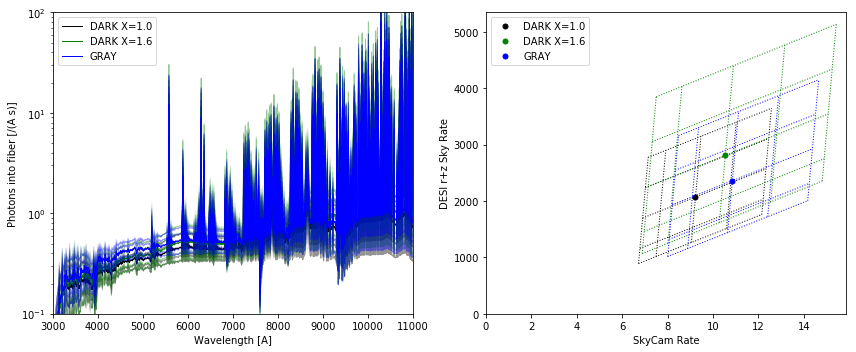

In [138]:
def emission_variations(fracs=(0.25, 0.5, 1.0, 1.5, 2.0), save=None):
    
    frac1, frac2 = np.meshgrid(fracs, fracs)
    nfrac = len(fracs)
        
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    for i, (name, lam, F, _) in enumerate(SKY):
        
        DESI_thru = desi_thru['r'](lam) + desi_thru['z'](lam)
        if name.startswith('BRIGHT'):
            continue
        else:
            SC_thru = sc_dark(lam)
        dlam = np.gradient(lam)
        '''
        F12 = F(1., 0.25)
        print(name, np.sum(F12 * dlam * DESI_thru))
        plt.plot(lam, F12, label=name)
        continue
        '''
        
        SC = []
        DESI = []
        c = 'kgbr'[i]
        for f1, f2 in zip(frac1.flat, frac2.flat):
            F12 = F(f1, f2)
            DESI.append(np.sum(F12 * dlam * DESI_thru))
            SC.append(np.sum(F12 * dlam * SC_thru))
            if f1 == 1 and f2 == 1:
                ax[0].plot(lam, F12, c=c, lw=1, label=name)
                ax[1].plot(SC[-1], DESI[-1], 'o', ms=5, c=c, label=name)
            else:
                ax[0].plot(lam, F12, c=c, lw=1, alpha=0.1)

        SC = np.array(SC).reshape(nfrac, nfrac)
        DESI = np.array(DESI).reshape(nfrac, nfrac)

        ax[0].set_xlim(lam[0], lam[-1])
        ax[1].plot(SC, DESI, c=c, lw=1, ls=':')
        ax[1].plot(SC.T, DESI.T, c=c, lw=1, ls=':')
            
    ax[0].set_yscale('log')
    ax[0].legend()
    ax[0].set_ylim(0.1, 1e2)
    ax[0].set_xlabel('Wavelength [A]')
    ax[0].set_ylabel('Photons into fiber [/(A s)]')
    
    ax[1].legend()
    ax[1].set_xlabel('SkyCam Rate')
    ax[1].set_ylabel('DESI r+z Sky Rate')
    ax[1].set_xlim(0, None)
    ax[1].set_ylim(0, None)
    
    plt.tight_layout()
    if save:
        plt.savefig(save)

emission_variations(save='xcal-emission.png')

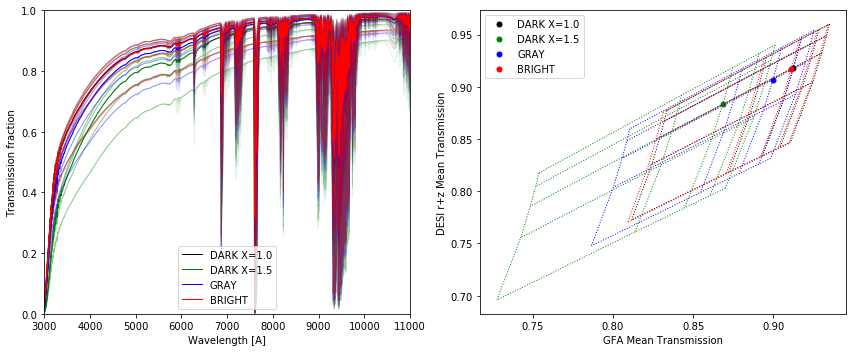

In [126]:
def transmission_variations(fracs=(0.2, 0.5, 1.0, 2.0, 5.0), save=None):
    
    frac1, frac2 = np.meshgrid(fracs, fracs)
    nfrac = len(fracs)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    for i, (name, lam, _, F) in enumerate(SKY):
        
        DESI_thru = desi_thru['r'](lam) + desi_thru['z'](lam)
        GFA_thru = gfa_thru(lam)
        dlam = np.gradient(lam)
        
        GFA = []
        DESI = []
        c = 'kgbr'[i]
        for f1, f2 in zip(frac1.flat, frac2.flat):
            F12 = F(f1, f2)
            DESI.append(np.sum(F12 * DESI_thru) / np.sum(DESI_thru))
            GFA.append(np.sum(F12 * GFA_thru) / np.sum(GFA_thru))
            if f1 == 1 and f2 == 1:
                ax[0].plot(lam, F12, c=c, lw=1, label=name)
                ax[1].plot(GFA[-1], DESI[-1], 'o', ms=5, c=c, label=name)
            else:
                ax[0].plot(lam, F12, c=c, lw=1, alpha=0.1)

        GFA = np.array(GFA).reshape(nfrac, nfrac)
        DESI = np.array(DESI).reshape(nfrac, nfrac)

        ax[0].set_xlim(lam[0], lam[-1])
        ax[1].plot(GFA, DESI, c=c, lw=1, ls=':')
        ax[1].plot(GFA.T, DESI.T, c=c, lw=1, ls=':')
            
    ax[0].legend()
    ax[0].set_ylim(0, 1)
    ax[0].set_xlabel('Wavelength [A]')
    ax[0].set_ylabel('Transmission fraction')
    
    ax[1].legend()
    ax[1].set_xlabel('GFA Mean Transmission')
    ax[1].set_ylabel('DESI r+z Mean Transmission')
    #ax[1].set_xlim(0, None)
    #ax[1].set_ylim(0, None)
    
    plt.tight_layout()
    if save:
        plt.savefig(save)

transmission_variations(save='xcal-transmission.png')

## GFA Simulation

Use the simulation package in https://desi.lbl.gov/trac/browser/code/online/CCD/Simulation/trunk/python/Simulation/simulation.py installed with:
```
svn co https://desi.lbl.gov/svn/code/online/CCD/Simulation/trunk CCDSimulation
```

In [59]:
import simulation

In [65]:
S = simulation.Simulation({'sim_type': 'star_galsim', 'image_size': [1000, 2000]})

In [66]:
img = S.create_simulation()

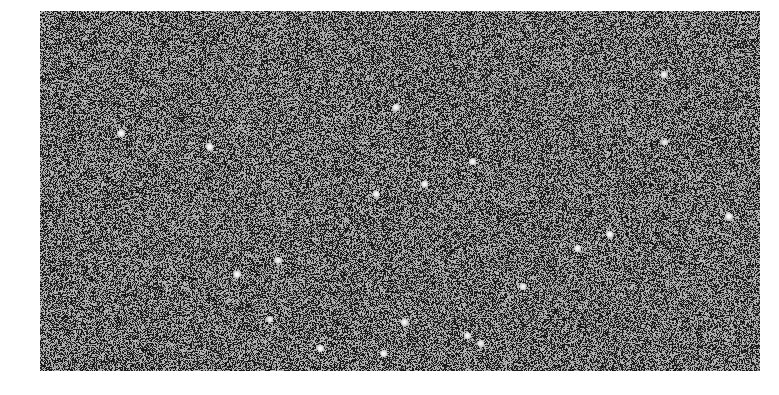

In [76]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.arcsinh(img), interpolation='none', cmap='gray')
ax.axis('off');
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig('GFAsim.png')